# Question on CNNs

1.	Write the data-loader
2.	Use data augmentation techniques to increase the size of the training set.
3.	Train the CNN model (implementing early stopping to prevent overfitting is better)
4.  Plot loss values
5.  Show a few samples of the train and test set
6.	Evaluate the model on the test set and report the accuracy and loss.
7.  provide the labels of the test_set in a file labelled Submission.csv. Submission.cvs should have a column called labels which should contain the labels of all the images

In [ ]:
#idx2numpy will be used to read the data 
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget -O data.zip https://www.dropbox.com/s/by3l3l9xe4iiara/data%202.zip?dl=0

--2023-05-12 14:49:03--  https://www.dropbox.com/s/by3l3l9xe4iiara/data%202.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/by3l3l9xe4iiara/data%202.zip [following]
--2023-05-12 14:49:03--  https://www.dropbox.com/s/raw/by3l3l9xe4iiara/data%202.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0e2f36ecadb76b07673282a60.dl-eu.dropboxusercontent.com/cd/0/inline/B77lxOCULjJSZyc-H1qBOQ3WfcqspFdhSWES-fQYLET6WXAhWWKdvJnIKBd47cPupT6PuNGWDcPE2rrWBy7nwFYGSXuvltSZC_PZaMwKi01-mp-lqatvlA-ob-iZGTBXKYEfMkL6NhkAGFslp9huq4Rki4Sp4JhqsPIqHVCnM8TWqQ/file# [following]
--2023-05-12 14:49:03--  https://ucb0e2f36ecadb76b07673282a60.dl-eu.dropboxusercontent.com/cd/0/inline/B77lxOCULjJSZyc-H1qBOQ3WfcqspFdhSWES-fQYLET6WXAhWWKdvJnIKBd47cPupT6Pu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import imageio as Image
from torchvision.datasets import MNIST

%matplotlib inline

In [ ]:
cd data

/content/data/data


In [ ]:
import os
if os.path.exists("data/"):
  pass

else:
  !unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
!ls data/

ls: cannot access 'data/': No such file or directory


In [ ]:
import idx2numpy
train_images = idx2numpy.convert_from_file('train-images-idx3')
test_images = idx2numpy.convert_from_file('test-images-idx3')

train_labels = idx2numpy.convert_from_file('train-labels-idx1')
test_labels = idx2numpy.convert_from_file('test-labels-idx1')

In [ ]:
len(train_images)

60000

In [ ]:
len(test_images)

10000

Write the data-loader

In [ ]:
batch_sz=10

train_loader = DataLoader(train_images, batch_size = batch_sz)
test_loader = DataLoader(test_images, batch_size = batch_sz)

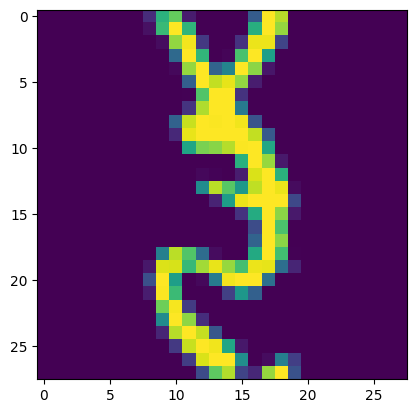

In [ ]:
plt.imshow(train_images[3])

In [ ]:
#!mkdir 'Train_images'

In [ ]:
print(train_loader)

In [ ]:
#---> t=[shift down,up,right,left] i will iterate through these values
class Translate:
  def __init__(self, t):
    self.t = t

  def __call__(self, im):
    shp = im.size()
    print(shp)
    for i,v in enumerate(self.t):
      print(i,v)
      if v>0 and i==0:
        pad = torch.zeros(shp[0], v, shp[2])
        im = torch.cat((pad, im), 1)
        im = im[:,:shp[1],:shp[2]]

      if v>0 and i==1:
        pad = torch.zeros(shp[0], v, shp[2])
        im = torch.cat(( im, pad), 1)
        im = im[:,v:,:shp[2]]

      if v>0 and i==2:
        pad = torch.zeros(shp[0], shp[1], v)
        im = torch.cat((pad, im), 2)
        im = im[:,:shp[1],:shp[2]]

      if v>0 and i==3:
        pad = torch.zeros(shp[0], shp[1], v)
        im = torch.cat(( im, pad), 2)
        im = im[:,:shp[1],v:]


    im = im[:,:shp[1],:shp[2]]
    return im


In [ ]:
from torchvision import transforms
toTensor = transforms.ToTensor()

class MyDataset(Dataset):
  def __init__(self, transform=None):
    super().__init__()
    
    self.image  = idx2numpy.convert_from_file('train-images-idx3')
    self.labels = idx2numpy.convert_from_file('train-labels-idx1')
    self.transform = transform


  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    im = self.image[idx]
    if self.transform:
      im = self.transform(im)
    label = self.labels[idx]
    return (im, label)

In [ ]:
transform_train = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                        
                    ])
transform_test = transforms.Compose([
                        transforms.ToTensor(),])

Text(0.5, 1.0, '7')

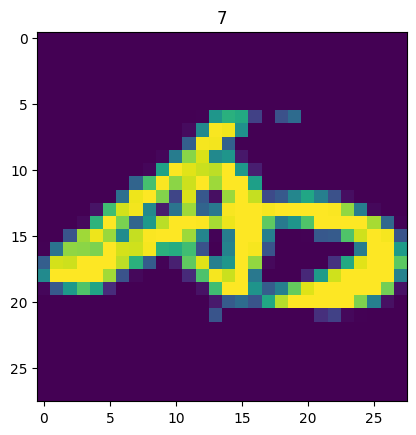

In [ ]:
dataset = MyDataset(transform=toTensor)
plt.imshow(dataset[1][0].permute((1,2,0)))
plt.title(dataset[1][1])

CNN Model 

In [ ]:
train_loader = DataLoader(dataset, batch_size = batch_sz)
test_loader = DataLoader(dataset, batch_size = batch_sz)

In [ ]:
class My_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,10,3,1,1) 
    self.conv2 = nn.Conv2d(10,50,3,1,1) 

    self.linear1 = nn.Linear(50*7*7,100)
    self.linear2 = nn.Linear(100,10)

  def forward(self,x):
    x = self.conv1(x)
    x = torch.relu(x)
    #x = torch.MaxPool2d(2,2)
    x = F.max_pool2d(x,(2,2))
    # x --->(10,16,16) 

    x = self.conv2(x)
    x = torch.relu(x)
    #x = torch.MaxPool2d(2,2)
    x = F.max_pool2d(x,(2,2)) 
    ## x --->(50,8,8)
    x = x.view(-1,50*7*7) 
    x = self.linear1(x)
    x = self.linear2(x)

    return x

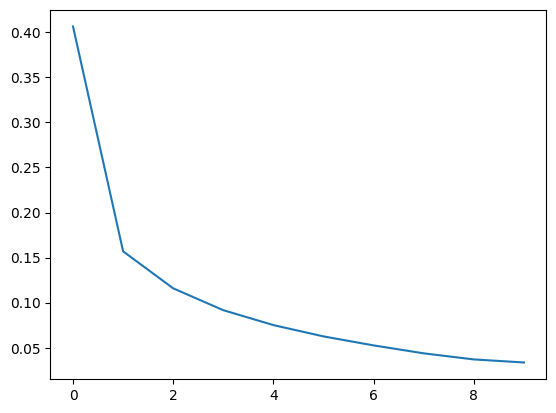

In [ ]:
device = torch.device("cuda:0")
network = My_CNN().to(device)
lr = 1e-2
mm = 0.5

opt = optim.SGD(network.parameters(), lr = lr, momentum = mm)
epoches = 10

ls = []

for i in range(epoches):
  total_loss = 0
  for batch in train_loader:
    #print(batch[0])
    X,y = batch[0].to(device), batch[1].to(device)
    y_hat = network(X)
    loss = F.cross_entropy(y_hat, y) #what is F?
    opt.zero_grad() 
    loss.backward()
    opt.step() 
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))
plt.plot(ls)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Evaluate the model on the testing dataset
from torchmetrics import Accuracy
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

acc = []
testing_labels = []
#true_testing_labels = []
with torch.no_grad(): 
  correct = 0
  total = 0

for batch in test_loader:
  X,y = batch[0].to(device),batch[1].to(device)
  yhat = network(X)
  #testing_labels.append(yhat)
  #true_testing_labels.append(y)
  labels = torch.argmax(yhat, dim=1)
  correct+=torch.sum(y==labels)
  total+=y.shape[0]
  #print(y)
  accur = accuracy(labels, y)
  acc.append(accur)
  labels = labels.cpu()

print(f"Accuracy is {correct/total}")

Accuracy is 0.9826833605766296


Text(0.5, 1.0, '1')

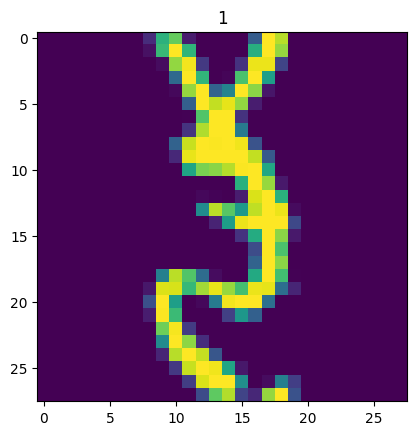

In [ ]:
#plot the dataset from training dataset
plt.imshow(dataset[3][0].permute((1,2,0)))
plt.title(dataset[3][1])

In [ ]:
#testing dataset
class MyDataset2(Dataset):
  def __init__(self, transform=None):
    super().__init__()
    
    self.image  = idx2numpy.convert_from_file('test-images-idx3')
    self.labels = idx2numpy.convert_from_file('test-labels-idx1')
    self.transform = transform


  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    im = self.image[idx]
    if self.transform:
      im = self.transform(im)
    label = self.labels[idx]
    return (im, label)

Text(0.5, 1.0, '3')

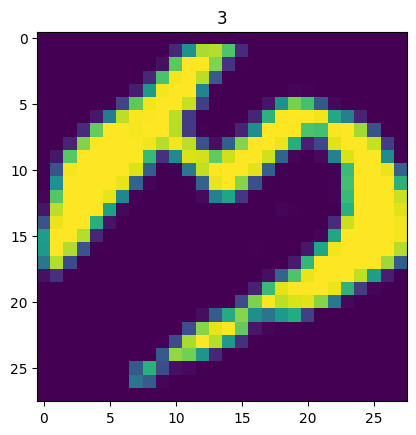

In [ ]:
#plot the dataset from training dataset
dataset2 = MyDataset2(transform=toTensor)
plt.imshow(dataset2[4][0].permute((1,2,0)))
plt.title(dataset2[4][1])

In [ ]:
#create and save the testing labels on csv file
import pandas as pd
df = pd.DataFrame(labels, columns=['Model_Labels'])
df

,Model_Labels
0,5
1,9
2,2
3,2
4,7
5,4
6,9
7,0
8,4
9,9


In [ ]:
df.to_csv("Submission.csv")